In [3]:
import torch
import sklearn

### Create Dataset for classification


In [5]:
from sklearn.datasets import make_circles

n_samples=1000
X,y=make_circles(n_samples,noise=0.03,random_state=42)

In [7]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [9]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [11]:
X.shape, y.shape

((1000, 2), (1000,))

#### Convert data into pytorch

In [13]:
import torch

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [15]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [17]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [21]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(700, 300, 700, 300)

### Build Model

In [23]:
from torch import nn

In [25]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [39]:
class FirstPytorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(in_features=2, out_features=10)
        self.layer2=nn.Linear(in_features=10, out_features=1)

    def forward(self,X):
        return self.layer2(self.layer1(X))

model0 = FirstPytorchModel().to(device)
model0

FirstPytorchModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
#predicting with untrained model

ut_preds=model0(X_test.to(device))
#check if the shapes are correct
print(f"prediction shape: \n{ut_preds.shape}\n\ntest labels shape: \n{Y_test.shape}\n\n")
print(f"Untrained predictions: \n{ut_preds[:10]}\n\n")
print(f"Actual lables for test data: \n{Y_test[:10]}\n\n")

prediction shape: 
torch.Size([300, 1])

test labels shape: 
torch.Size([300])


Untrained predictions: 
tensor([[-0.1566],
        [ 0.0115],
        [-0.3692],
        [-0.0972],
        [-0.0075],
        [ 0.0922],
        [ 0.2788],
        [ 0.2986],
        [-0.3842],
        [ 0.0268]], grad_fn=<SliceBackward0>)


Actual lables for test data: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])




In [43]:
## Loss function and Optimizer

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),lr=0.01)

##Set an evaluation metric, lets say accuracy for now. 
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [45]:
#Adding Sigmoid activation function to the output layer to convert outputs to probablities and rounding the probablities
prob_preds = torch.sigmoid(ut_preds)
round_prob_preds = torch.round(prob_preds)
round_prob_preds[:10]

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]], grad_fn=<SliceBackward0>)

### Training the model

In [56]:
#set sedd and epochs
torch.manual_seed(42)

epochs =100
acc_track=[]
train_loss=[]
test_losss=[]
test_acc_track=[]
#bring data to the device
X_train, Y_train, X_test, Y_test = X_train.to(device), Y_train.to(device),X_test.to(device),Y_test.to(device)

for epoch in range(epochs):

    #set model to training mode
    model0.train()

    
    raw_preds= model0(X_train).squeeze()
    preds= torch.round(torch.sigmoid(raw_preds))
    loss = loss_fn(raw_preds,Y_train)
    acc_score= accuracy_fn(Y_train,preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss)
    acc_track.append(acc_score)

    ##testing loop

    model0.eval()

    test_preds= model0(X_test).squeeze()
    preds= torch.round(torch.sigmoid(test_preds))
    test_loss = loss_fn(test_preds,Y_test)
    test_acc= accuracy_fn(Y_test,preds)
    

    test_losss.append(test_loss)
    test_acc_track.append(test_acc)
    

    if epoch % 10 ==9:

        print(f"Epoch: {epoch}\nTraining loss: {loss} | Accuracy: {acc_score}\nTest Loss: {test_loss}  | Test Accuracy: {test_acc}n\n")
        
        # for param_group in optimizer.param_groups:
        #      for param in param_group['params']:
        #          print(param.data)  
        

    

Epoch: 9
Training loss: 0.6940701603889465 | Accuracy: 52.28571428571429
Test Loss: 0.6985905766487122  | Test Accuracy: 47.66666666666667n

Epoch: 19
Training loss: 0.6940170526504517 | Accuracy: 52.42857142857142
Test Loss: 0.6985301971435547  | Test Accuracy: 47.66666666666667n

Epoch: 29
Training loss: 0.6939666271209717 | Accuracy: 52.85714285714286
Test Loss: 0.6984707713127136  | Test Accuracy: 47.333333333333336n

Epoch: 39
Training loss: 0.6939186453819275 | Accuracy: 52.714285714285715
Test Loss: 0.698412299156189  | Test Accuracy: 47.333333333333336n

Epoch: 49
Training loss: 0.6938729286193848 | Accuracy: 52.714285714285715
Test Loss: 0.6983547210693359  | Test Accuracy: 47.66666666666667n

Epoch: 59
Training loss: 0.693829357624054 | Accuracy: 52.57142857142857
Test Loss: 0.6982980370521545  | Test Accuracy: 48.0n

Epoch: 69
Training loss: 0.6937877535820007 | Accuracy: 52.714285714285715
Test Loss: 0.6982423663139343  | Test Accuracy: 48.0n

Epoch: 79
Training loss: 0.693

In [58]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


Matplotlib is building the font cache; this may take a moment.


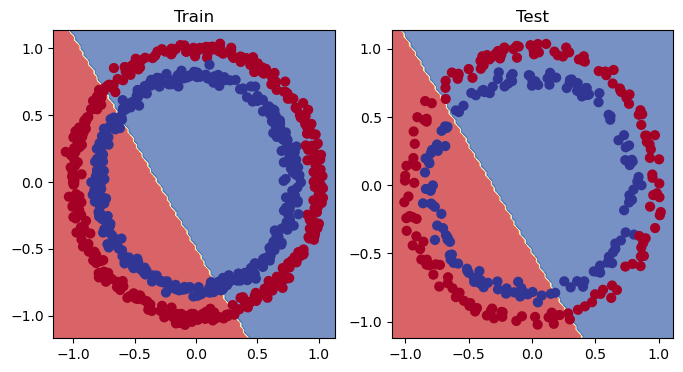

In [72]:
##plotting decision boundary
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0,X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0,X_test,Y_test)

### Correcting model to capture non-linearity

In [151]:
class FirstPytorchModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(in_features=2, out_features=5)
        self.layer2=nn.Linear(in_features=5, out_features=10)
        self.layer3=nn.Linear(in_features=10, out_features=1)
        #Adding this activation function to capture non-linearity
        self.relu=nn.ReLU()

    def forward(self,X):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(X)))))

model1 = FirstPytorchModel2().to(device)
model1

FirstPytorchModel2(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [173]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.05)

In [175]:
#set sedd and epochs
torch.manual_seed(42)

epochs =10000
epoch_track= range(epochs)
acc_track=[]
train_loss=[]
test_losss=[]
test_acc_track=[]
#bring data to the device
X_train, Y_train, X_test, Y_test = X_train.to(device), Y_train.to(device),X_test.to(device),Y_test.to(device)

for epoch in range(epochs):

    #set model to training mode
    model1.train()

    
    raw_preds= model1(X_train).squeeze()
    preds= torch.round(torch.sigmoid(raw_preds))
    loss = loss_fn(raw_preds,Y_train)
    acc_score= accuracy_fn(Y_train,preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss)
    acc_track.append(acc_score)

    ##testing loop

    model1.eval()

    test_preds= model1(X_test).squeeze()
    preds= torch.round(torch.sigmoid(test_preds))
    test_loss = loss_fn(test_preds,Y_test)
    test_acc= accuracy_fn(Y_test,preds)
    

    test_losss.append(test_loss)
    test_acc_track.append(test_acc)
    

    if epoch % 100 ==0:

        print(f"Epoch: {epoch}\nTraining loss: {loss} | Accuracy: {acc_score}\nTest Loss: {test_loss}  | Test Accuracy: {test_acc}n\n")
        
        # for param_group in optimizer.param_groups:
        #      for param in param_group['params']:
        #          print(param.data)  
        

    

Epoch: 0
Training loss: 0.3786598742008209 | Accuracy: 98.85714285714286
Test Loss: 0.3860239088535309  | Test Accuracy: 96.33333333333334n

Epoch: 100
Training loss: 0.321483850479126 | Accuracy: 99.0
Test Loss: 0.33215779066085815  | Test Accuracy: 97.0n

Epoch: 200
Training loss: 0.2672799825668335 | Accuracy: 99.28571428571429
Test Loss: 0.28278273344039917  | Test Accuracy: 97.66666666666667n

Epoch: 300
Training loss: 0.2202145755290985 | Accuracy: 99.42857142857143
Test Loss: 0.24039794504642487  | Test Accuracy: 97.66666666666667n

Epoch: 400
Training loss: 0.18222714960575104 | Accuracy: 99.57142857142857
Test Loss: 0.20530037581920624  | Test Accuracy: 98.0n

Epoch: 500
Training loss: 0.15223537385463715 | Accuracy: 99.57142857142857
Test Loss: 0.1770317256450653  | Test Accuracy: 99.0n

Epoch: 600
Training loss: 0.12945948541164398 | Accuracy: 99.28571428571429
Test Loss: 0.1544470489025116  | Test Accuracy: 99.33333333333333n

Epoch: 700
Training loss: 0.11134979128837585 |

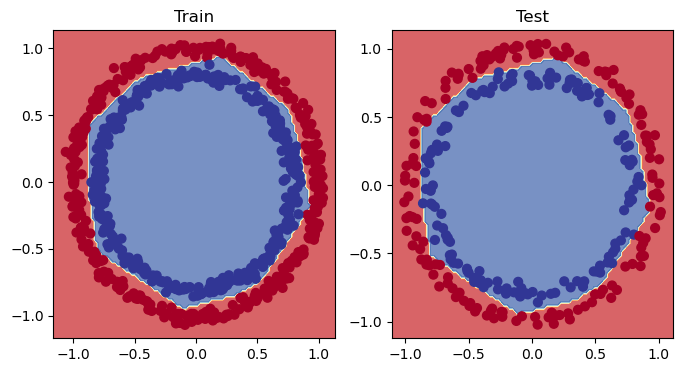

In [177]:
##plotting decision boundary
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1,X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1,X_test,Y_test)

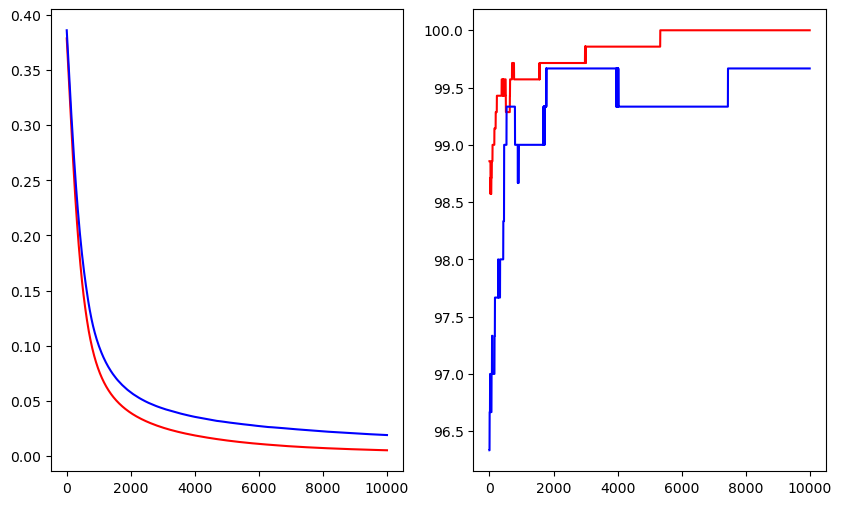

In [179]:
##plotting training and testing losses and accuracy scores 
f = lambda x: torch.tensor(x).detach().numpy()
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot( epoch_track, f(train_loss), color='red', label ="Training loss")
plt.plot( epoch_track, f(test_losss), color='blue', label =" loss")
plt.subplot(1,2,2)
plt.plot( epoch_track, f(acc_track), color='red', label ="Training Accuracy")
plt.plot( epoch_track, f(test_acc_track), color='blue', label ="Testing Accuracy")


In [171]:
torch.tensor(train_loss).detach().numpy()

array([0.6894636 , 0.6894603 , 0.68945694, ..., 0.37899998, 0.37888664,
       0.37877327], dtype=float32)

## Multi-Class Classification

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


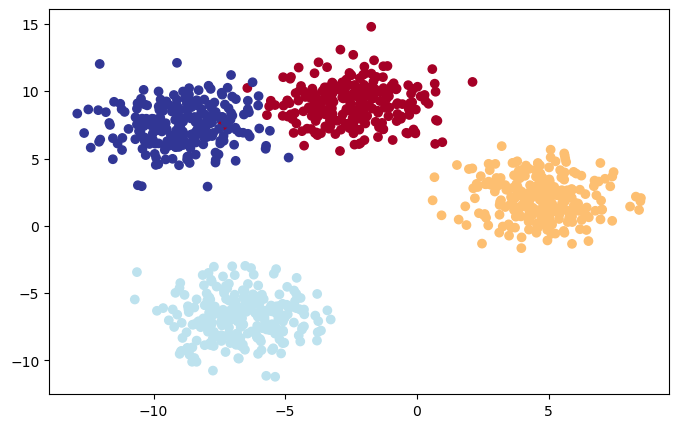

In [190]:
from sklearn.datasets import make_blobs

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(8, 5))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [202]:
y_blob_train

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
        3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 0, 0, 0,
        1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2,
        3, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 0, 0, 1, 2, 1,
        3, 1, 2, 1, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 2, 0, 2, 0, 3, 2,
        0, 0, 2, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 2,
        3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 3, 3, 3, 0, 2, 0, 1,
        2, 2, 2, 3, 0, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 1, 1, 2, 2, 2,
        2, 2, 2, 0, 3, 3, 2, 1, 1, 2, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 3,
        1, 0, 0, 1, 0, 3, 2, 1, 0, 3, 0, 0, 3, 1, 0, 1, 0, 2, 2, 0, 0, 3, 3, 2,
        0, 2, 0, 3, 1, 3, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 3, 1, 1, 0, 2,
        2, 3, 1, 0, 1, 2, 3, 1, 2, 0, 3, 1, 3, 3, 3, 0, 3, 3, 3, 2, 3, 3, 1, 0,
        2, 2, 2, 2, 3, 1, 2, 2, 0, 2, 3,

In [224]:
raw_preds= model1(X_blob_train).squeeze()
preds= torch.argmax(torch.softmax(raw_preds,dim=1),dim=1)
preds[:5]

tensor([1, 0, 3, 3, 0])

In [228]:
y_blob_train[:5]

tensor([1, 0, 2, 2, 0])

In [230]:
torch.eq(preds, y_blob_train).sum().item()

407

In [236]:
preds.shape

torch.Size([800])

In [238]:
correct = torch.eq(preds, y_blob_train).sum().item() # torch.eq() calculates where two tensors are equal
acc = (correct / len(preds)) * 100 
acc

50.875

In [196]:
## Model Architechture
class MultiClassModel(nn.Module):
    def __init__(self,in_,out,hid):
        super().__init__()
        self.layer1=nn.Linear(in_features=in_, out_features=hid)
        self.layer2=nn.Linear(in_features=hid, out_features=out)

    def forward(self,X):
        return self.layer2(self.layer1(X))

model1 = MultiClassModel(NUM_FEATURES,NUM_CLASSES,10).to(device)
model1

MultiClassModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=4, bias=True)
)

In [194]:
class MultiClassModel2(nn.Module):
    def __init__(self,in_,out,hid):
        super().__init__()
        self.linear_stack=nn.Sequential(
        nn.Linear(in_features=in_, out_features=hid),
        nn.Linear(in_features=hid, out_features=out)
        )
    def forward(self,X):
        return self.linear_stack(X)

model1 = MultiClassModel2(NUM_FEATURES,NUM_CLASSES,10).to(device)
model1

MultiClassModel2(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [198]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.05)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [246]:
##TEST TRAIN LOOP
#set sedd and epochs
torch.manual_seed(42)

epochs =10000
epoch_track= range(epochs)
acc_track=[]
train_loss=[]
test_losss=[]
test_acc_track=[]
#bring data to the device
X_blob_train, y_blob_train, X_blob_test, y_blob_test = X_blob_train.to(device), y_blob_train.to(device),X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):

    #set model to training mode
    model1.train()

    
    raw_preds= model1(X_blob_train).squeeze()
    preds= torch.argmax(torch.softmax(raw_preds,dim=1),dim=1)
    loss = loss_fn(raw_preds,y_blob_train)
    acc_score= accuracy_fn(y_blob_train,preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss)
    acc_track.append(acc_score)

    ##testing loop

    model1.eval()

    test_raw_preds= model1(X_blob_test).squeeze()
    test_preds= torch.argmax(torch.softmax(test_raw_preds,dim=1),dim=1)
    test_loss = loss_fn(test_raw_preds,y_blob_test)
    test_acc= accuracy_fn(y_blob_test,test_preds)
    

    test_losss.append(test_loss)
    test_acc_track.append(test_acc)
    

    if epoch % 100 ==0:

        print(f"Epoch: {epoch}\nTraining loss: {loss} | Accuracy: {acc_score}\nTest Loss: {test_loss}  | Test Accuracy: {test_acc}n\n")
        
        # for param_group in optimizer.param_groups:
        #      for param in param_group['params']:
        #          print(param.data)  
        

    


Epoch: 0
Training loss: 0.3652316629886627 | Accuracy: 95.625
Test Loss: 0.3275678753852844  | Test Accuracy: 99.0n

Epoch: 100
Training loss: 0.053300369530916214 | Accuracy: 99.125
Test Loss: 0.04648038372397423  | Test Accuracy: 99.5n

Epoch: 200
Training loss: 0.03887498751282692 | Accuracy: 99.125
Test Loss: 0.0310616847127676  | Test Accuracy: 99.5n

Epoch: 300
Training loss: 0.03372914716601372 | Accuracy: 99.125
Test Loss: 0.025343406945466995  | Test Accuracy: 99.5n

Epoch: 400
Training loss: 0.031111735850572586 | Accuracy: 99.125
Test Loss: 0.022314049303531647  | Test Accuracy: 99.5n

Epoch: 500
Training loss: 0.02953760325908661 | Accuracy: 99.125
Test Loss: 0.020416080951690674  | Test Accuracy: 99.5n

Epoch: 600
Training loss: 0.028490571305155754 | Accuracy: 99.125
Test Loss: 0.019103389233350754  | Test Accuracy: 99.5n

Epoch: 700
Training loss: 0.02774445340037346 | Accuracy: 99.125
Test Loss: 0.018133966252207756  | Test Accuracy: 99.5n

Epoch: 800
Training loss: 0.0

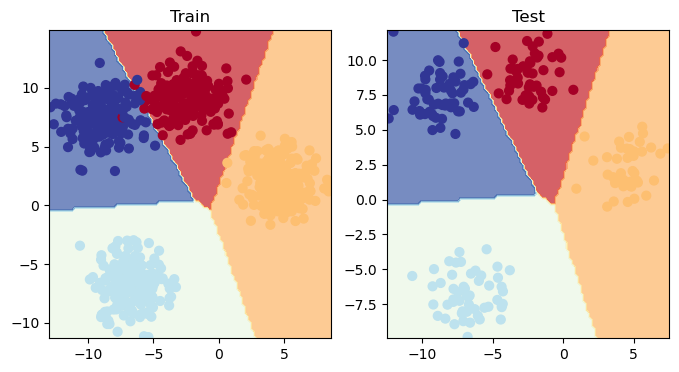

In [248]:
##plotting decision boundary
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1,X_blob_test,y_blob_test)